In [93]:
from warnings import filterwarnings
filterwarnings("ignore")
from datetime import timedelta
import random 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
from crypto_momentum_portfolios.utility.types import (
    DataFrequency,
    Fields,
    RebalanceFrequency,
    Side,
    RankingMode,
    AllocationMethod,
    RankingMethod,
    AllocationMode,
    Benchmark,
)

from crypto_momentum_portfolios.utility.data_loader import CryptoDataLoaderQIL

dl = CryptoDataLoaderQIL()  # CryptoDataLoader()
dl.assets

Fetching symbols...: 100%|██████████| 21/21 [00:00<00:00, 210.41it/s]


['SOL-USDT',
 'TRX-USDT',
 'XTZ-USDT',
 'ETC-USDT',
 'ATOM-USDT',
 'ADA-USDT',
 'DASH-USDT',
 'AVAX-USDT',
 'BCH-USDT',
 'BNB-USDT',
 'ETH-USDT',
 'LINK-USDT',
 'EOS-USDT',
 'VET-USDT',
 'MATIC-USDT',
 'LTC-USDT',
 'XLM-USDT',
 'XRP-USDT',
 'BTC-USDT',
 'DOGE-USDT',
 'KDA-USDT']

In [7]:
MOMENTUM_LOOKBACK = 30
universe = (
    dl.get_crypto(
        "all",
        data_frequency=DataFrequency.DAILY,
        fields=[
            Fields.RETURNS,
        ],
        flatten_fields_with_crypto=False,
    )
    .dropna()
)

universe.head()

returns                                                    \
            SOL-USDT  TRX-USDT  XTZ-USDT  ETC-USDT ATOM-USDT  ADA-USDT   
Date                                                                     
2021-08-05  0.043325  0.040791  0.012553  0.015202  0.016885  0.006463   
2021-08-06  0.058501  0.025720  0.041495  0.010811  0.042940  0.011617   
2021-08-07 -0.005109  0.045910  0.020881  0.142044  0.033057  0.050641   
2021-08-08 -0.041136 -0.044426 -0.069759 -0.057269 -0.064005 -0.031951   
2021-08-09  0.027893  0.028663  0.032415  0.035828  0.039084  0.034587   

                                                    ...                      \
           DASH-USDT AVAX-USDT  BCH-USDT  BNB-USDT  ... LINK-USDT  EOS-USDT   
Date                                                ...                       
2021-08-05  0.019326  0.011022  0.005150  0.009080  ... -0.005020  0.018230   
2021-08-06  0.017197  0.063533  0.014713  0.012650  ... -0.008797  0.030412   
2021-08-07  0.018520  0.075148  0.048351  0.040498  ...  0.035351  0.063825   
2021-08-08 -0.052613 -0.064844 -0.047080 -0.040197  ... -0.067473 -0.064438   
2021-08-09  0.108593  0.091621  0.064964  0.037064  ...  0.050831  0.055236   

                                                                         \
            VET-USDT MATIC-USDT  LTC-USDT  XLM-USDT  XRP-USDT  BTC-USDT   
Date                                                                      
2021-08-05  0.026869   0.009955  0.005526 -0.000646  0.002366  0.028817   
2021-08-06  0.063791   0.014739  0.031110  0.016123  0.019470  0.048335   
2021-08-07  0.073552   0.077713  0.054472  0.079485  0.093643  0.040495   
2021-08-08 -0.024659  -0.071852 -0.039613 -0.066205 -0.047102 -0.017535   
2021-08-09  0.044928   0.042268  0.111645  0.040777  0.048980  0.056544   

                                
           DOGE-USDT  KDA-USDT  
Date                            
2021-08-05 -0.002879  0.010854  
2021-08-06  0.018864  0.022635  
2021-08-07  0.279189  0.030079  
2021-08-08 -0.083559  0.122314  
2021-08-09  0.068425  0.075356  

[5 rows x 21 columns]

# 1. Defining the optimal lookback & holding period

## 1.1 Computing the ability of past returns to predict future returns on different timeframes.

### A. Predicting 1 month returns

In [71]:
class ReturnPrediction:

    @staticmethod
    def check_frequency(data: pd.DataFrame):
        if data.index.to_series().diff().mean() != timedelta(days=1):
            raise ValueError("Provide a daily index DataFrame.")
        
    @staticmethod
    def get_average_past_returns(returns: pd.DataFrame, nb_days: int) -> pd.DataFrame:
        """Returns a DataFrame containing average past returns for the specified period."""
        ReturnPrediction.check_frequency(returns)
        return returns.rolling(nb_days).mean().shift(1)
    
    @staticmethod
    def get_average_future_returns(returns: pd.DataFrame, nb_days: int) -> pd.DataFrame:
        ReturnPrediction.check_frequency(returns)
        return (returns
                .iloc[::-1]
                .rolling(nb_days)
                .mean()
                .iloc[::-1]
        )
    
    @staticmethod
    def get_average_versus_future_returns_corr(returns: pd.DataFrame, lookback: int, horizon: int) -> pd.DataFrame:
        """Give the correlation between average past returns and average future returns."""
        past_returns = ReturnPrediction.get_average_past_returns(returns, lookback)
        future_returns = ReturnPrediction.get_average_future_returns(returns, horizon)
        corr = past_returns.corrwith(future_returns)
        corr.name = f"{lookback}/{horizon}"
        return corr
    
    @staticmethod
    def get_corr_for_all_lookback(returns: pd.DataFrame, horizon: int):
        """
        Compute the correlation of all the possible lookbacks periods with a sample size
        of at least 30,  for a given horizon.
        """
        max_lookback = len(returns) - horizon - 30
        if max_lookback <= 0:
            raise ValueError("Wrong combination of horizon & lookback: not enought data")

        lookbacks = np.arange(2, max_lookback)
        correlations = [ReturnPrediction.get_average_versus_future_returns_corr(returns, lookback, horizon)
                        for lookback in lookbacks]
        return pd.concat(correlations, axis=1), lookbacks

corr_for_lookbacks, lookbacks = ReturnPrediction.get_corr_for_all_lookback(universe["returns"], 30)
corr_for_lookbacks.head()

,2/30,3/30,4/30,5/30,6/30,7/30,8/30,9/30,10/30,11/30,...,813/30,814/30,815/30,816/30,817/30,818/30,819/30,820/30,821/30,822/30
SOL-USDT,0.128663,0.152021,0.170385,0.184081,0.192036,0.194837,0.197111,0.202139,0.199339,0.200437,...,-0.434864,-0.448576,-0.466720,-0.443312,-0.437459,-0.447067,-0.451704,-0.462718,-0.474265,-0.515159
TRX-USDT,-0.080164,-0.099489,-0.104344,-0.104895,-0.092278,-0.080730,-0.073022,-0.061961,-0.059027,-0.050157,...,0.267322,0.189161,0.063186,0.014044,0.028563,0.060767,0.147271,0.155226,0.155348,0.075231
XTZ-USDT,-0.039870,-0.045557,-0.042963,-0.036868,-0.024494,-0.009165,0.000220,0.004861,0.001259,0.002866,...,-0.555949,-0.605606,-0.690743,-0.708599,-0.777548,-0.833877,-0.821103,-0.817523,-0.801790,-0.787085
ETC-USDT,0.025574,0.021848,0.016446,0.012437,0.006595,-0.005263,-0.015269,-0.019074,-0.028989,-0.036289,...,-0.361219,-0.468530,-0.594988,-0.546737,-0.462460,-0.292970,-0.053373,0.068669,0.020565,-0.080376
ATOM-USDT,0.031510,0.062230,0.090319,0.119329,0.148018,0.172397,0.190333,0.202685,0.201950,0.205244,...,0.133999,0.048582,-0.079567,-0.080644,-0.186649,-0.180495,-0.077445,-0.044911,-0.086171,-0.138821


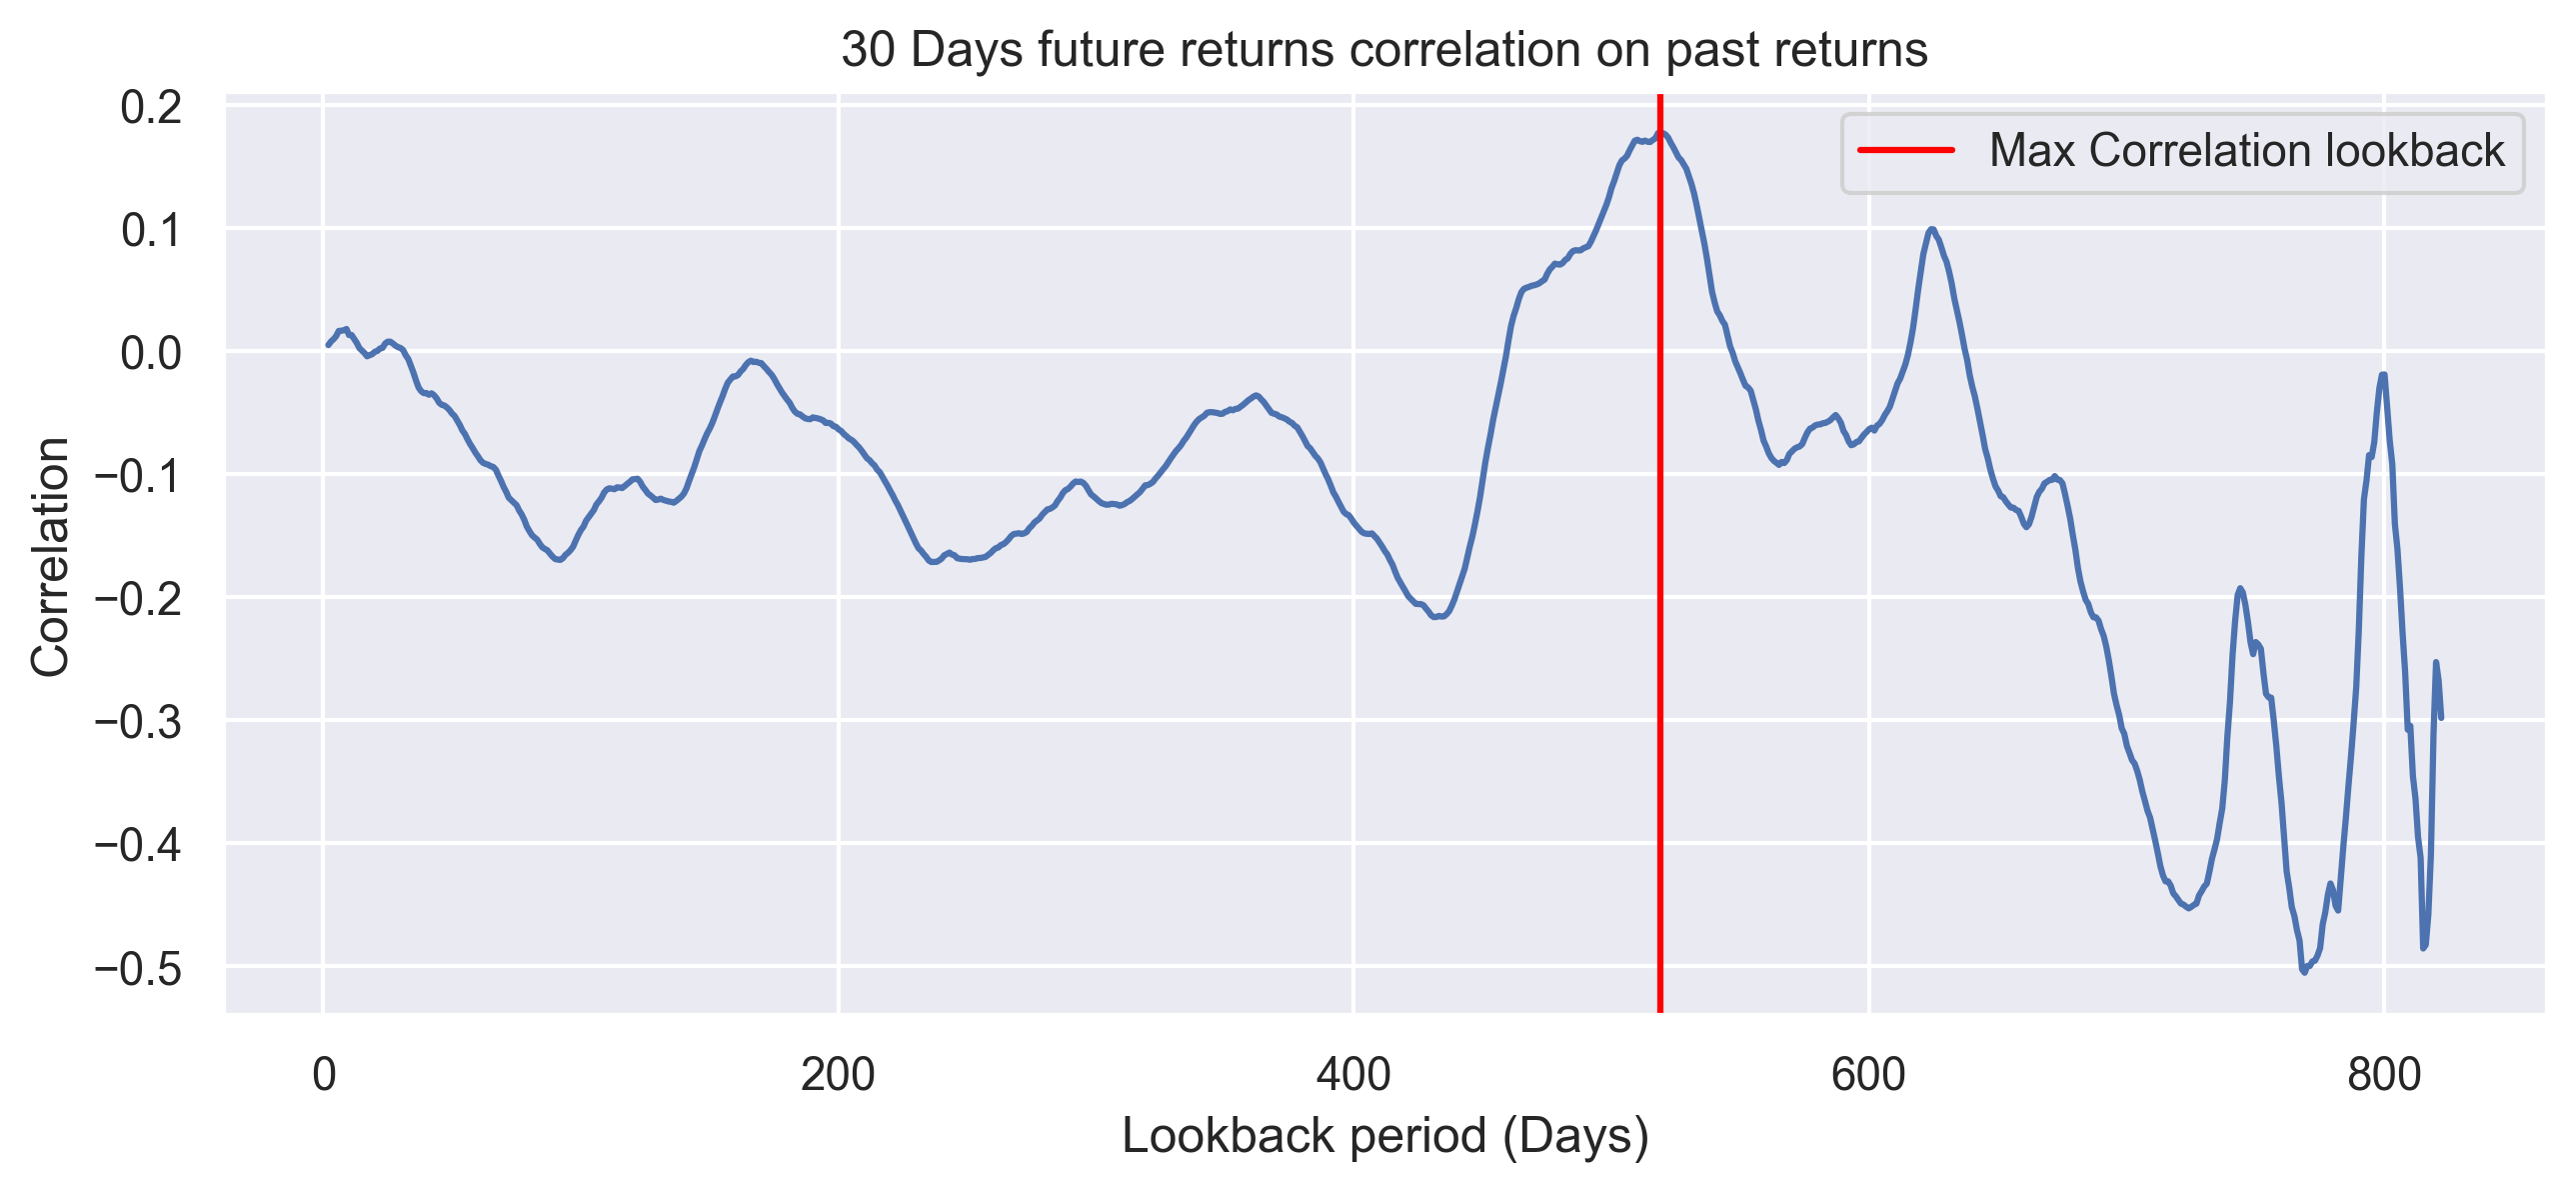

In [70]:
means_corr = corr_for_lookbacks.mean()

fig, ax = plt.subplots(1, figsize=(10, 4), dpi=300)
ax.plot(lookbacks, means_corr)
ax.axvline(
    int(means_corr.idxmax().split("/")[0]),  # Lookback which maximise the corr coeff
    color="red",
    label="Max Correlation lookback"
)
ax.set_title("30 Days future returns correlation on past returns")
ax.set_xlabel("Lookback period (Days)")
ax.set_ylabel("Correlation")
ax.legend()


> Do you know what's interesting? Different timeframes can have different effects on cross-sectional momentum trading. Short-term lookback periods, usually less than a month, may lead to mean reversion and disrupt momentum. And if we go too long, beyond a year, we might see unwanted return reversals. Instead, focus on intermediate-term lookback periods ranging from one to twelve months. They offer consistent returns without troublesome reversals. It's like finding the sweet spot for optimal cross-sectional momentum trading to maximise your success, it’s where the magic happens!

https://www.linkedin.com/pulse/cross-sectional-momentum-trading-strategy-quantra-classroom/

In [79]:
def compute_all_combinations(returns: pd.DataFrame):
    horizons = np.arange(10, 100, 10)
    return [
        ReturnPrediction.get_corr_for_all_lookback(universe["returns"], horizon)
        for horizon in horizons
    ], horizons
    
combinations, horizons = compute_all_combinations(universe["returns"])

Best combination - lookback: 519 | horizon: 30


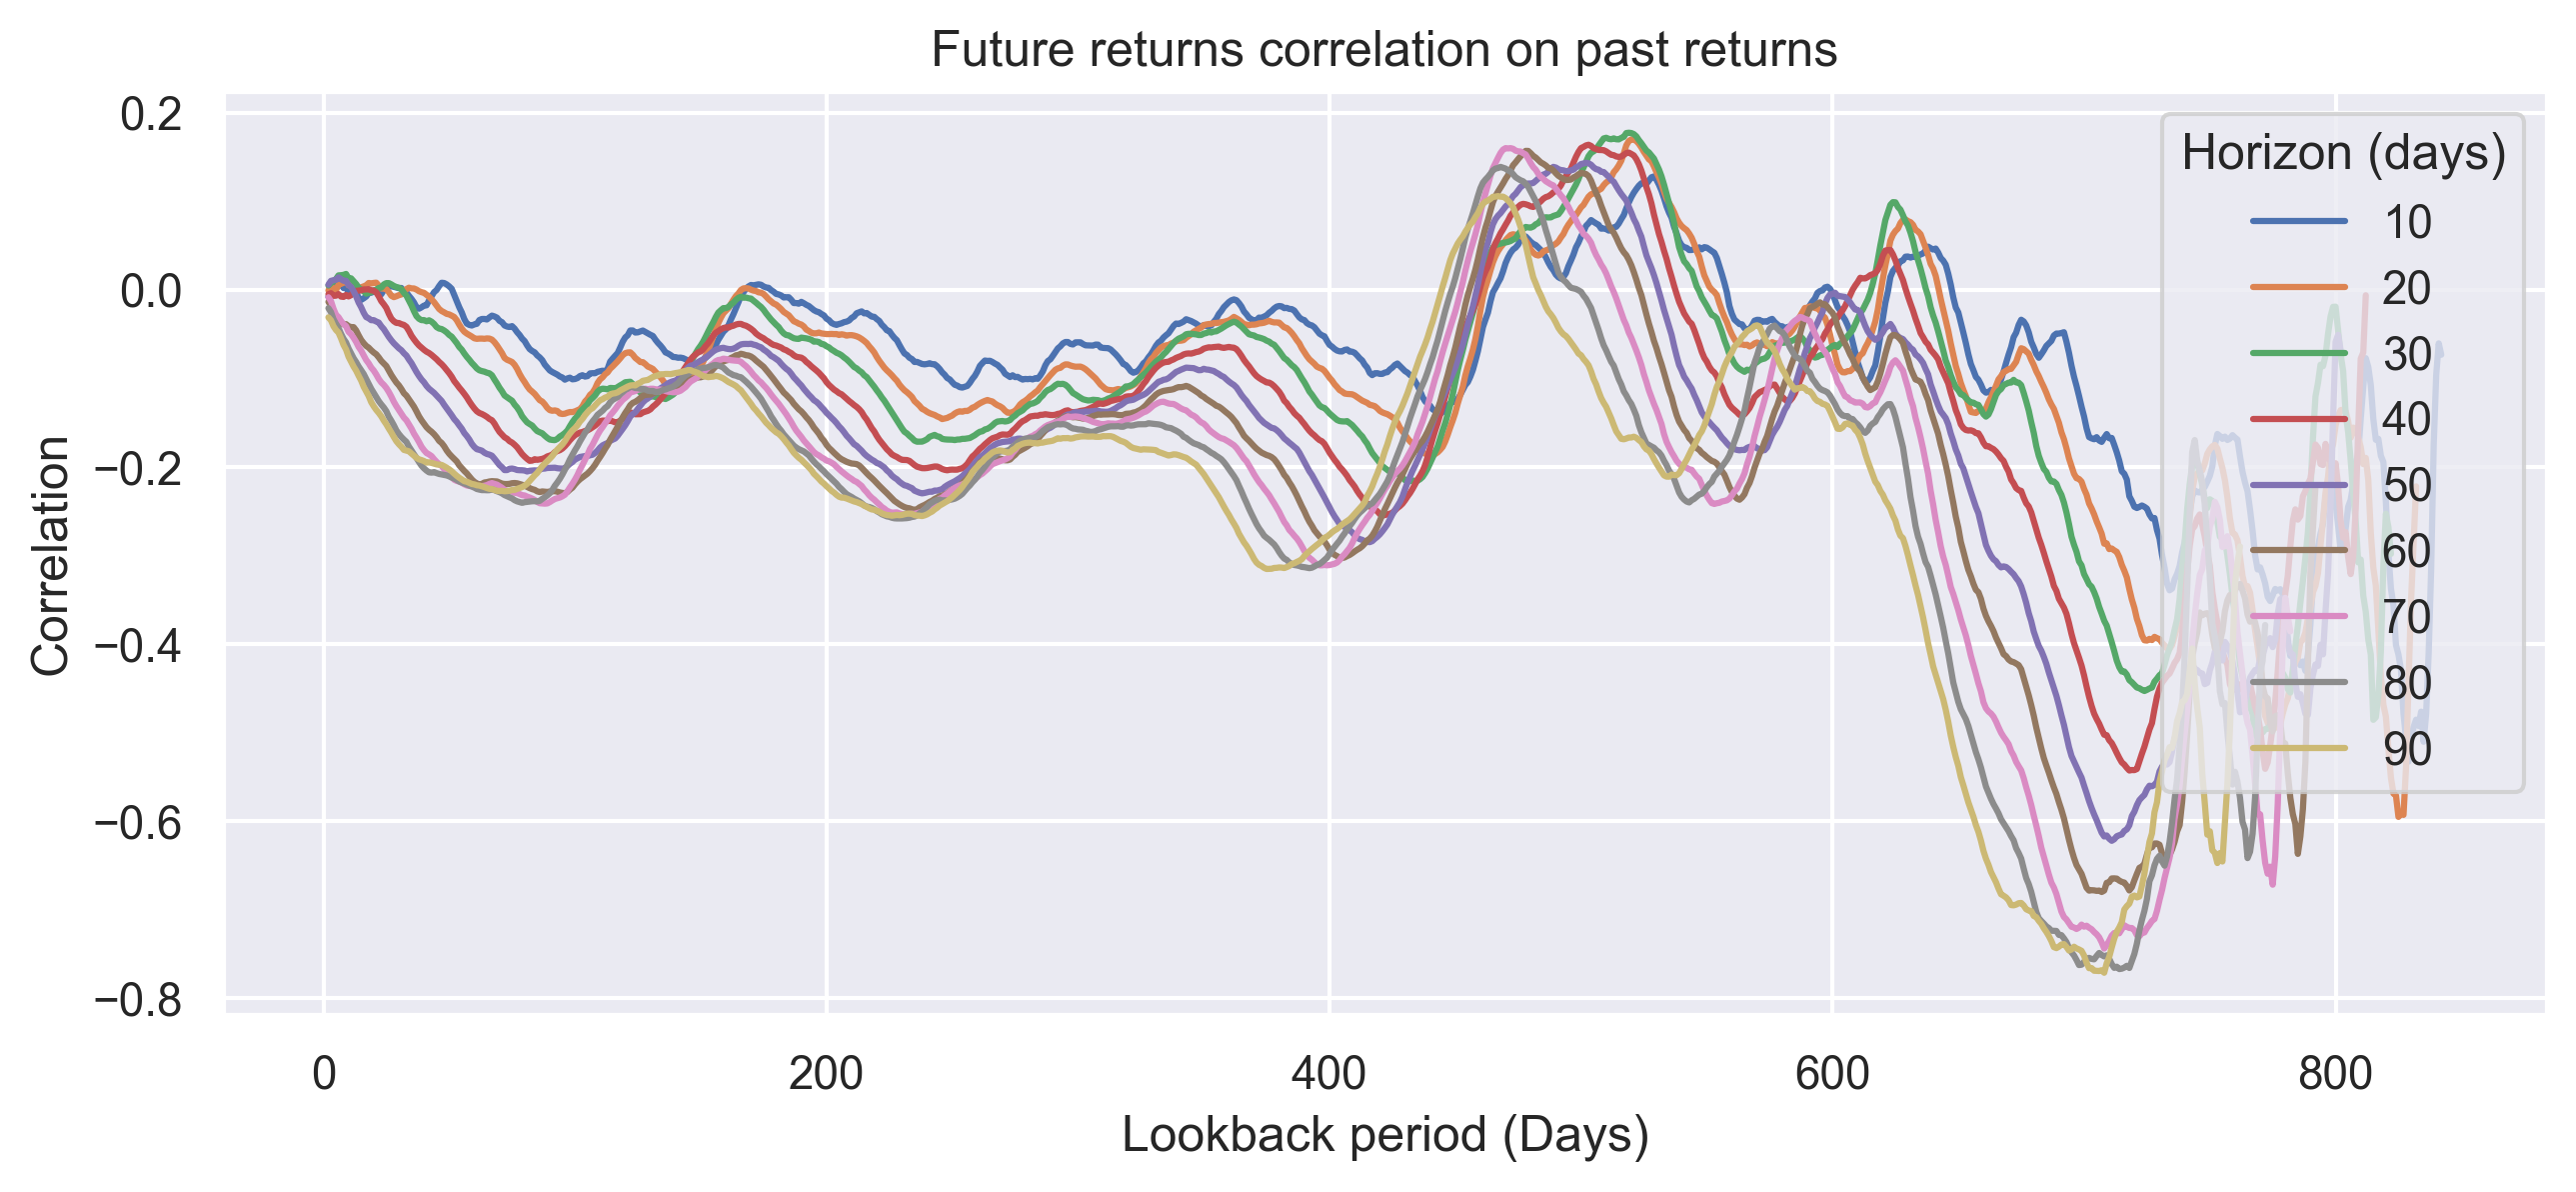

In [108]:
fig, ax = plt.subplots(1, figsize=(10, 4), dpi=300)

for combination, horizon in zip(combinations, horizons):
    sns.lineplot(
        x=combination[1], 
        y=combination[0].mean(), 
        label=horizon,
    )

ax.legend(title="Horizon (days)")
ax.set_title("Future returns correlation on past returns")
ax.set_xlabel("Lookback period (Days)")
ax.set_ylabel("Correlation")

def get_optimal_parameters(combinations: list):
    max_value = 0
    best_combination = ""
    for combination in combinations:
        mean = combination[0].mean()
        if mean.max() > max_value:
            max_value = mean.max()
            best_combination = mean.idxmax()
    
    lookback, horizon = best_combination.split("/")
    return int(lookback), int(horizon), max_value

best_lookback, best_horizon, max_value = get_optimal_parameters(combinations)
print(f"Best combination - lookback: {best_lookback} | horizon: {best_horizon}")

For most horizons, ~500 days seems to be the best lookback period.

# 2. Assessing results stability

In [103]:
class ResultStability:
    def __init__(self, 
                 returns: pd.DataFrame,
                 lookback: int,
                 horizon: int) -> None:
        self.returns = returns
        self.tickers = list(returns.columns)
        self.cut = 2 * int(len(self.tickers) / 3)  # Keep only 2/3 of the universe
        self.lookback = lookback
        self.horizon = horizon

    def __get_random_universe(self):
        random.shuffle(self.tickers)
        new_universe = self.tickers[:self.cut]
        return self.returns[new_universe]
    
    def perform(self, nb_draws: int):
        universe = self.__get_random_universe()
        return [
            ReturnPrediction.get_average_versus_future_returns_corr(
                self.__get_random_universe(),
                self.lookback,
                self.horizon
            ).mean()
            for _ in range(nb_draws)
        ]
    
stability = ResultStability(universe["returns"], best_lookback, best_horizon)
res = stability.perform(50)

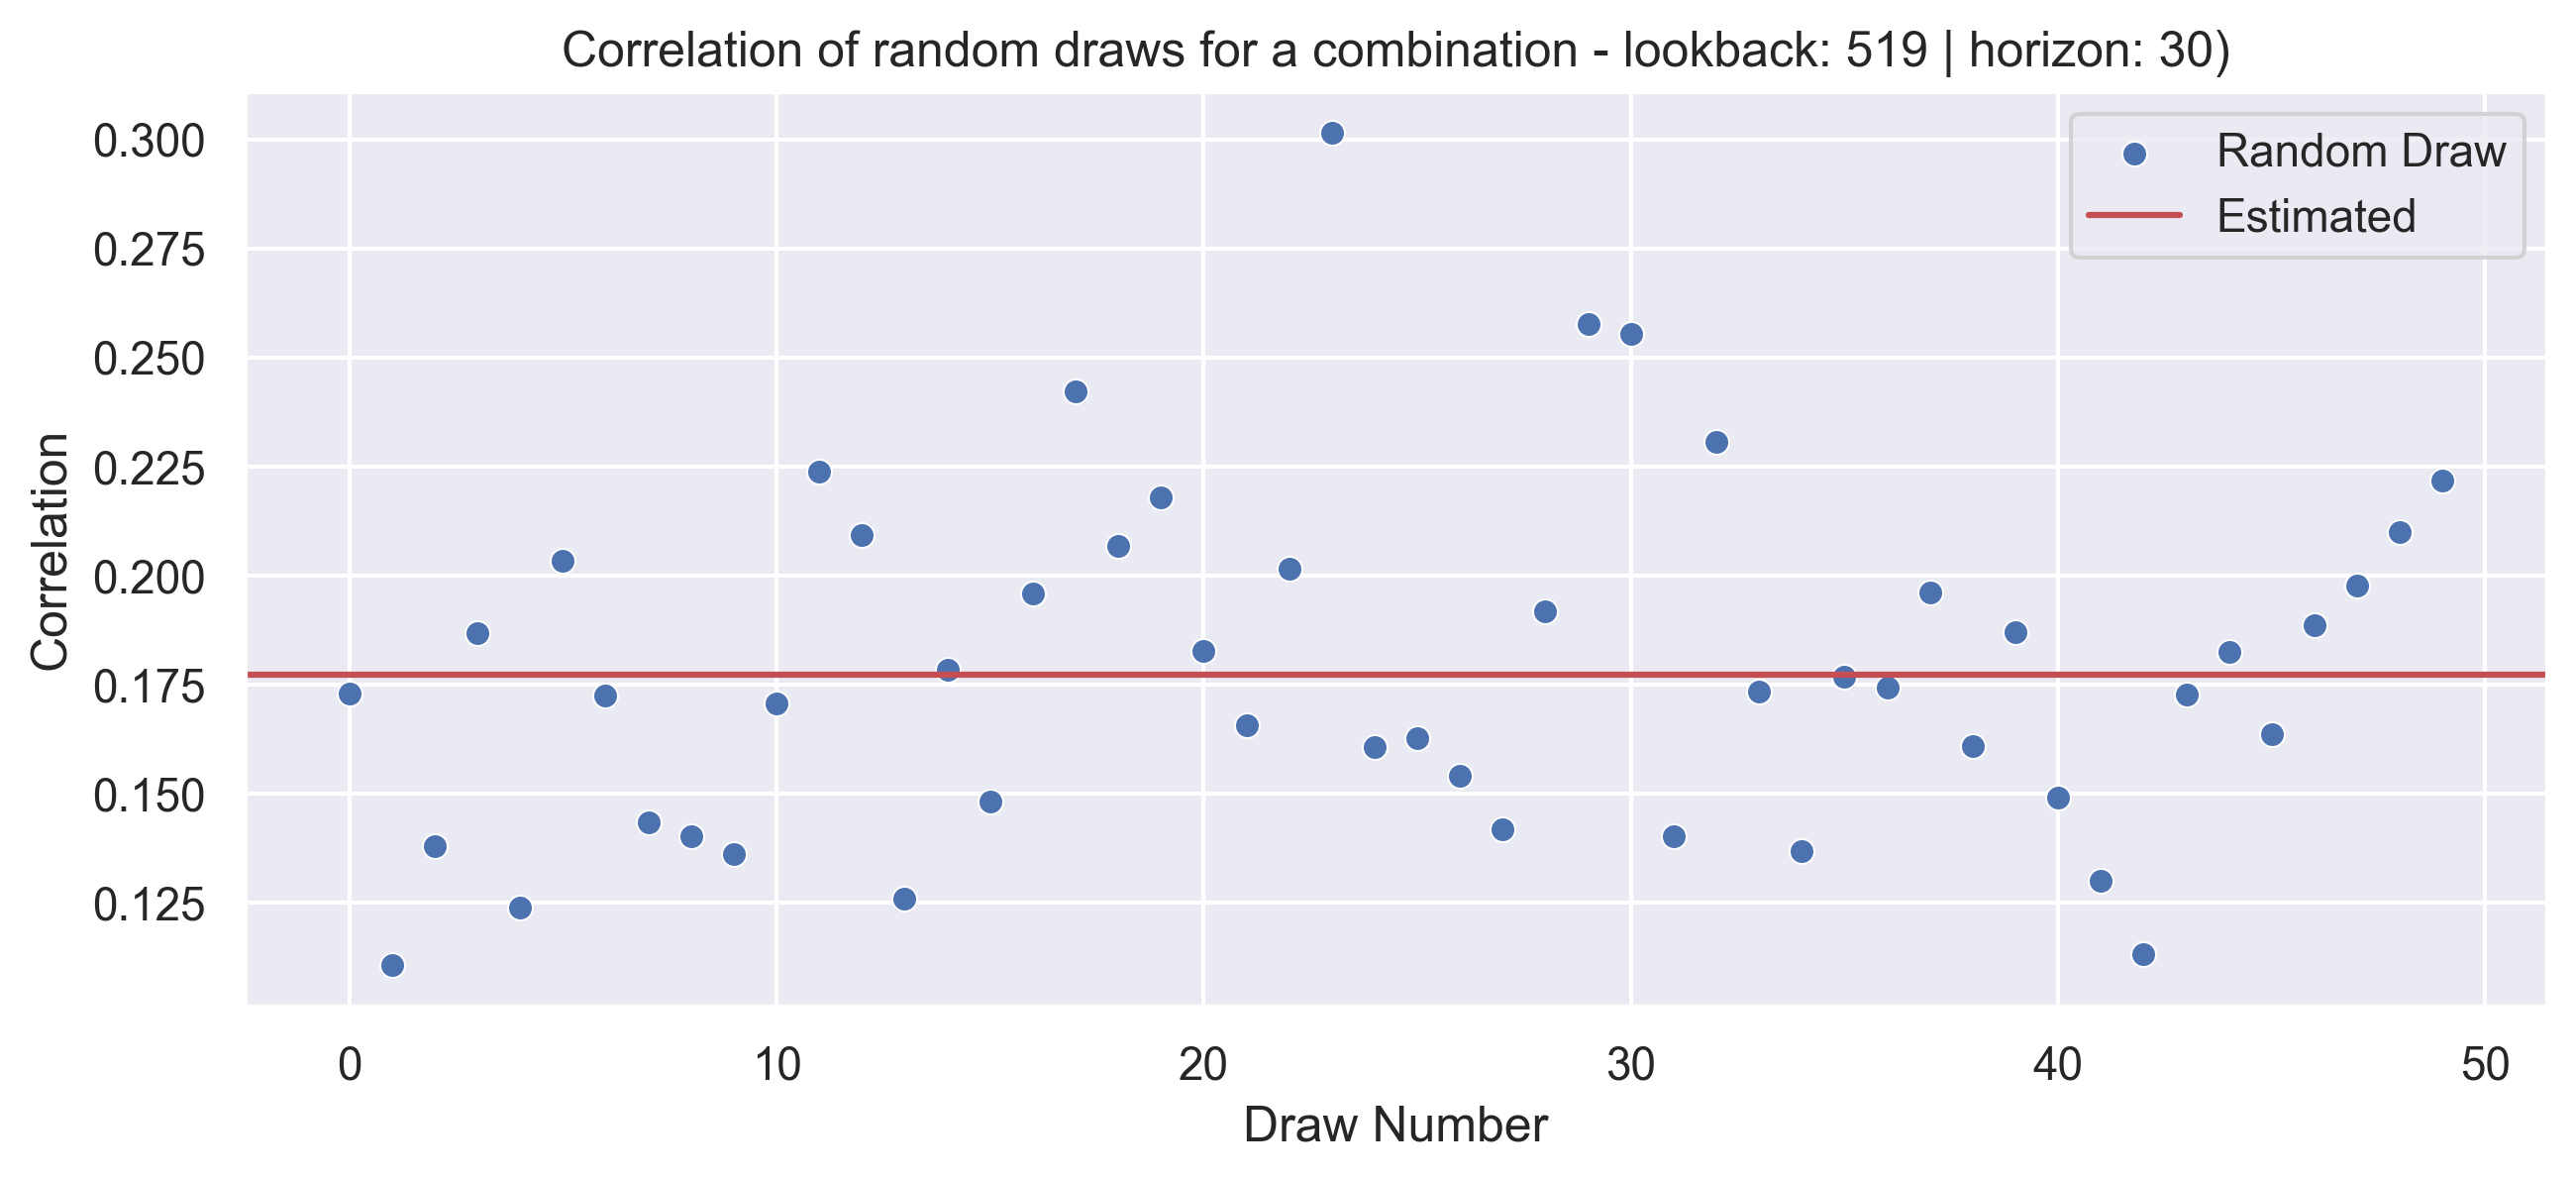

In [110]:
fig, ax = plt.subplots(1, figsize=(10, 4), dpi=300)

sns.scatterplot(
    x=np.arange(0, len(res)),
    y=res,
    label="Random Draw"
)

ax.set_title("Dispersion of results")
ax.set_xlabel("Draw Number")
ax.set_ylabel("Correlation")
ax.set_title(f"Correlation of random draws for a combination - lookback: {best_lookback} | horizon: {best_horizon})")
ax.axhline(max_value, label="Estimated", color="r")
ax.legend()

Lots of dispersion but results do not look overfitted